## parsing harps website

* [HARPS bank](https://www2.mpia-hd.mpg.de/homes/trifonov/HARPS_RVBank.html)

In [36]:
from urllib.request import urlopen, urlretrieve
from os.path import exists
from os.path import join
import sys

import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_3d
from astropy.io import ascii
from astroplan.plots import plot_finder_image
import matplotlib.pyplot as pl
from astropy.visualization.wcsaxes import SphericalCircle
import matplotlib.cm as cm
from collections import OrderedDict
import numpy as np
from tqdm import tqdm
from glob import glob
import sys
sys.path.append('../archive_digger/')
import archive_digger as ad

In [2]:
df = ad.get_harps_database(clobber=False)

Loaded: ../data/harps_db.csv


In [3]:
df.shape

(5105, 14)

In [4]:
ra, dec = 338.805332, 54.773557
coords = SkyCoord(ra=ra, dec=dec, unit=u.deg)

In [5]:
res = ad.query_target(coords, df, dist=10*u.arcsec)
res


Querying objects within 10.0 arcsec of ra,dec=(338.805332,54.773557)

Nearest HARPS obj to target is
HD218935: ra,dec=(347.9550,26.8473)

Try angular distance larger than d=103381.3599"



In [37]:
toi = 6713.01
q = ad.query_toi(toi=toi, tic=None, clobber=False)
r = q['RA'].values[0]
d = q['Dec'].values[0]
target_coord = SkyCoord(ra=r, dec=d, unit=(u.hourangle, u.deg))
res = ad.query_target(target_coord, df, dist=10*u.arcsec)
res

Loaded: ../data/TOIs.csv

Querying objects within 10.0 arcsec of ra,dec=(179.79237499999996,-20.355605555555556)

There are 1 matches: ['HD104067']
                                                1172
G [mag]                                        7.632
Dist [pc]                                      20.35
Explore data (GLS)         GLS of RVs | Inspect data
Data products (dat)  HD104067_HARPS_RVBank_ver02.dat
Data products (csv)  HD104067_HARPS_RVBank_ver02.csv
RA_deg                                    179.791703
DEC_deg                                   -20.353781




,Target,RA,DEC,Sp. Type,T_eff [K],B [mag],V [mag],G [mag],Dist [pc],Explore data (GLS),Data products (dat),Data products (csv),RA_deg,DEC_deg
1172,HD104067,11:59:10.0088,-20:21:13.612,K2V,NaN,8.897,7.921,7.632,20.35,GLS of RVs | Inspect data,HD104067_HARPS_RVBank_ver02.dat,HD104067_HARPS_RVBank_ver02.csv,179.791703,-20.353781


In [7]:
res.columns

Index(['Target', 'RA', 'DEC', 'Sp. Type', 'T_eff [K]', 'B [mag]', 'V [mag]',
       'G [mag]', 'Dist [pc]', 'Explore data (GLS)', 'Data products (dat)',
       'Data products (csv)', 'RA_deg', 'DEC_deg'],
      dtype='object')

In [8]:
ad.ALL_DATA_PRODUCTS

['Data products (dat)', 'Data products (csv)']

In [18]:
r = res.iloc[0]
rv = ad.get_rv(r, col='Data products (csv)', return_fp=False)
rv

,target,ra,dec,BJD,RV_mlc_nzp,e_RV_mlc_nzp,RV_drs_nzp,e_RV_drs_nzp,RV_mlc,e_RV_mlc,...,PROGPI,AIRMASS,OBHAB,THAR_FP,DPR_TYPE,RHKp,dRHKp,sourceflag,vsinflag,metflag
0,GJ9201,91.090165,-55.31161,2.452989e+06,-0.020262,1.929829,263357.960908,3.558502,-5.544069,1.729180,...,Mayor,-9999999,HARPS_ech_obs_all,HARPS_ech_obs_objA,STAR_DARK_K,1.284732e-05,4.412264e-06,1,0,0
1,GJ9201,91.090165,-55.31161,2.452999e+06,3.532469,2.313156,15438.394042,4.548864,-1.904377,2.148608,...,Mayor,-9999999,HARPS_ech_obs_all,HARPS_ech_obs_objA,STAR_DARK_K,3.856967e-05,2.497980e-04,1,0,0
2,GJ9201,91.090165,-55.31161,2.453008e+06,-0.116337,1.060328,243334.652244,1.186930,-5.453131,0.624597,...,Mayor,-9999999,HARPS_ech_obs_all,HARPS_ech_obs_objA,STAR_DARK_K,1.479507e-05,4.381160e-06,1,0,0
3,GJ9201,91.090165,-55.31161,2.453296e+06,3.423486,1.576467,42159.508396,2.731336,-3.004980,1.456430,...,Mayor,-9999999,HARPS_ech_obs_all,HARPS_ech_obs_objA,STAR_DARK_K0,1.096707e-05,1.672691e-06,1,0,0
4,GJ9201,91.090165,-55.31161,2.453835e+06,-5.326543,1.502500,42155.186514,2.263147,-10.485645,1.366504,...,Mayor,-9999999,HARPS_ech_obs_all,HARPS_ech_obs_objA,STAR_DARK_K0,-9.999999e+06,-9.999999e+06,-9999999,-9999999,-9999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,GJ9201,91.090165,-55.31161,2.458918e+06,3.604071,1.592369,42666.953524,3.928806,-1.606917,1.005804,...,Bonfils,-9999999,HARPS_ech_obs_all,HARPS_ech_obs_objAB,STAR_SKY_M2,1.201255e-05,1.766867e-06,1,0,0
85,GJ9201,91.090165,-55.31161,2.458926e+06,3.585867,1.578294,42667.601840,3.908090,-2.686208,0.983315,...,UNKNOWN,-9999999,HARPS_ech_obs_all,HARPS_ech_obs_objAB,STAR_SKY_M2,2.016466e-05,6.376417e-06,1,0,0
86,GJ9201,91.090165,-55.31161,2.458928e+06,-0.813545,1.839502,42666.609311,4.889268,-7.147948,1.363750,...,UNKNOWN,-9999999,HARPS_ech_obs_all,HARPS_ech_obs_objAB,STAR_SKY_M2,1.473118e-05,2.817641e-06,1,0,0
87,GJ9201,91.090165,-55.31161,2.458930e+06,4.143025,1.860391,42671.628079,4.943096,-2.422639,1.391796,...,UNKNOWN,-9999999,HARPS_ech_obs_all,HARPS_ech_obs_objAB,STAR_SKY_M2,5.031135e-04,2.741016e-03,1,0,0


## finder chart

In [10]:
target_coord = SkyCoord(ra=target_coord.ra.deg, dec=target_coord.dec.deg, unit=(u.deg, u.deg))

Loaded: ../data/TOIs.csv


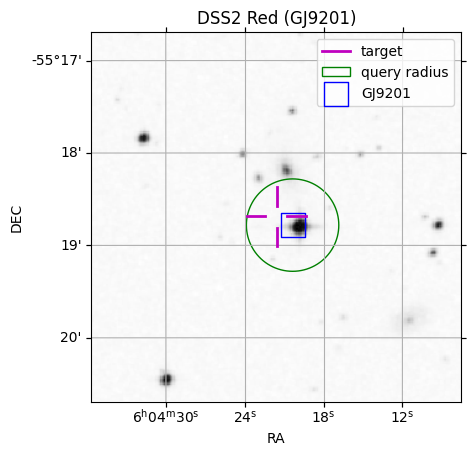

In [35]:
toi = 704.01
ang_dist = 30*u.arcsec
fov_rad = 120*u.arcsec
survey='DSS2 Red'

q = ad.query_toi(toi=toi, tic=None, clobber=False)
r = q['RA'].values[0]
d = q['Dec'].values[0]
target_coord = SkyCoord(ra=r, dec=d, unit=(u.hourangle, u.deg))
#convert hms to degree
target_coord = SkyCoord(target_coord.ra.deg, target_coord.dec.deg, unit=u.deg)
res = ad.query_target(target_coord, df, dist=ang_dist, verbose=False)

nearest_obj = res['Target'].values[0]
nearest_obj_ra,nearest_obj_dec =res[['RA_deg','DEC_deg']].values[0]
nearest_obj_coord = SkyCoord(ra=nearest_obj_ra, dec=nearest_obj_dec, unit=u.deg)

#target in reticle
ax,hdu=plot_finder_image(target_coord,fov_radius=fov_rad,reticle=True,survey=survey,reticle_style_kwargs={'label':'target'})
c = SphericalCircle((nearest_obj_ra, nearest_obj_dec)*u.deg, ang_dist, edgecolor='green', facecolor='none',
              transform=ax.get_transform('icrs'), label='query radius')
ax.set_title('{} ({})'.format(survey,nearest_obj))
ax.add_patch(c)

#harps objects within angular distance
coords = SkyCoord(ra=res['RA_deg'], dec=res['DEC_deg'], unit=u.deg)
sep2d = target_coord.separation(coords)

idxs = sep2d < ang_dist
colors = cm.rainbow(np.linspace(0, 1, idxs.sum()))

if len(coords[idxs])>1:
    for n,(coord,color) in enumerate(zip(coords[idxs],colors)):
        ax.scatter(coord.ra.deg, coord.dec.deg, transform=ax.get_transform('fk5'), s=300,
           marker='s', edgecolor=color, facecolor='none',label=res.loc[idxs,'Target'].values[n])
else:
    ax.scatter(coords.ra.deg, coords.dec.deg, transform=ax.get_transform('fk5'), s=300,
           marker='s', edgecolor='blue', facecolor='none',label=res['Target'].values[0])

handles, labels = pl.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
pl.legend(by_label.values(), by_label.keys())

In [14]:
from os.path import isdir 
from os import makedirs

outdir = '../data/v02/'
if outdir is None:
    outdir = nearest_obj
else:
    outdir = join(outdir,nearest_obj)
if not isdir(outdir):
    makedirs(outdir)
    
fp = join(outdir,'{}_fov.png'.format(nearest_obj))
ax.figure.savefig(fp,bbox_inches=False)
print("Saved: ", fp)

Saved:  ../data/v02/GJ9201/GJ9201_fov.png
